<a href="https://colab.research.google.com/github/zongming03/Feature-Engineering/blob/main/IndividualAssignment_WIE3007.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install featuretools
!pip install google-cloud-pubsub

import featuretools as ft
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.9/587.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.2/215.2 kB 10.9 MB/s eta 0:00:00


##Setup Google Cloud Pub/Sub

In [49]:
from google.oauth2 import service_account
import googleapiclient.discovery

creds = service_account.Credentials.from_service_account_file('/content/wie3007ia-196c883db361.json')


In [4]:
from google.cloud import pubsub_v1
from google.oauth2.service_account import Credentials


# Path to your service account JSON file
SERVICE_ACCOUNT_FILE = '/content/wie3007ia-196c883db361.json'

# Set up credentials
credentials = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE)

# Google Cloud Pub/Sub settings
project_id = "wie3007ia"
order_topic_id = "order-updates"
customer_topic_id = "customer-updates"


# Publisher Client
try:
    publisher = pubsub_v1.PublisherClient(credentials=credentials)
    order_topic_path = publisher.topic_path(project_id, order_topic_id)
    customer_topic_path = publisher.topic_path(project_id, customer_topic_id)
    print(f"Topic path initialized: {order_topic_path}")
    print(f"Topic path initialized: {customer_topic_path}")

except Exception as e:
    print(f"Error initializing Publisher Client: {e}")



Topic path initialized: projects/wie3007ia/topics/order-updates
Topic path initialized: projects/wie3007ia/topics/customer-updates


In [5]:
from google.cloud import pubsub_v1
from google.oauth2.service_account import Credentials

# Path to service account JSON file
SERVICE_ACCOUNT_FILE = '/content/wie3007ia-196c883db361.json'

# Set up credentials
credentials = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE)

# Project ID
project_id = "wie3007ia"

# Initialize Subscriber Client
try:
    subscriber = pubsub_v1.SubscriberClient(credentials=credentials)

    # Define subscription paths
    order_subscription_path = subscriber.subscription_path(project_id, "orderIA1122")
    customer_subscription_path = subscriber.subscription_path(project_id, "customersIA1122")

    print(f"Order Subscription Path: {order_subscription_path}")
    print(f"Customer Subscription Path: {customer_subscription_path}")

    # Callback for processing messages
    def callback(message):
        print(f"Received message: {message.data.decode('utf-8')}")
        message.ack()

    # Subscribe to the "orderIA1122" subscription
    streaming_pull_order = subscriber.subscribe(order_subscription_path, callback=callback)
    print(f"Listening for messages on {order_subscription_path}")

    # Subscribe to the "customersIA1122" subscription
    streaming_pull_customer = subscriber.subscribe(customer_subscription_path, callback=callback)
    print(f"Listening for messages on {customer_subscription_path}")

    # try:
    #     streaming_pull_order.result()
    #     streaming_pull_customer.result()
    # except KeyboardInterrupt:
    #     streaming_pull_order.cancel()
    #     streaming_pull_customer.cancel()
    #     print("Stopped listening for messages.")
    #need connect to GCE VM but dont have money

except Exception as e:
    print(f"Error initializing Subscriber Client: {e}")


Order Subscription Path: projects/wie3007ia/subscriptions/orderIA1122
Customer Subscription Path: projects/wie3007ia/subscriptions/customersIA1122
Listening for messages on projects/wie3007ia/subscriptions/orderIA1122
Listening for messages on projects/wie3007ia/subscriptions/customersIA1122


##Load Dataset

In [6]:
# Load data from Excel
file_path = '/content/Book1.xlsx'
customers_df = pd.read_excel(file_path, sheet_name='Customers')
products_df = pd.read_excel(file_path, sheet_name='Products')
orders_df = pd.read_excel(file_path, sheet_name='Orders')
order_details_df = pd.read_excel(file_path, sheet_name='OrderDetails')

###Convert to datetime

In [7]:
# Convert to datetime
# Convert to datetime with day-first format
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'], dayfirst=True)
orders_df['OrderDate'] = pd.to_datetime(orders_df['OrderDate'], dayfirst=True)
orders_df['ShipDate'] = pd.to_datetime(orders_df['ShipDate'], dayfirst=True)

##Clean Data


###Add Combined key in the order details

To add order details a unique key

In [8]:
# Add a combined key in the order details
order_details_df['OrderDetailsID'] = order_details_df['OrderID'].astype(str) + '_' + order_details_df['ProductID'].astype(str)

In [9]:
display(customers_df)
display(products_df)
display(orders_df)
display(order_details_df)

,CustomerID,Name,Email,SignupDate
0,101,John Doe,john.doe@example.com,2023-01-10
1,102,Jane Smith,jane.smith@example.com,2023-01-15
2,103,Mike Jordan,mike.jordan@example.com,2023-01-20
3,104,Emma Stone,emma.stone@example.com,2023-02-01
4,105,Chris Evans,chris.evans@example.com,2023-02-05
5,106,Alice Brown,alice.brown@example.com,2023-02-10
6,107,Bob Johnson,bob.johnson@example.com,2023-02-15
7,108,Charlie Davis,charlie.davis@example.com,2023-02-20
8,109,David Garcia,david.garcia@example.com,2023-03-01
9,110,Emily Wilson,emily.wilson@example.com,2023-03-05


,ProductID,Name,Category,Price
0,201,Laptop,Electronics,1000
1,202,Tablet,Electronics,500
2,203,Smartphone,Electronics,800
3,204,Headphones,Accessories,200
4,205,Smartwatch,Electronics,300
5,206,Mouse,Accessories,50
6,207,Keyboard,Accessories,100
7,208,Monitor,Electronics,300
8,209,Printer,Electronics,250
9,210,Webcam,Accessories,150


,OrderID,CustomerID,OrderDate,ShipDate
0,301,101,2023-02-01,2023-02-03
1,302,102,2023-02-05,2023-02-07
2,303,103,2023-02-10,2023-02-12
3,304,104,2023-02-12,2023-02-14
4,305,105,2023-02-15,2023-02-17
5,306,106,2023-02-20,2023-02-22
6,307,107,2023-02-22,2023-02-25
7,308,108,2023-03-01,2023-03-03
8,309,109,2023-03-05,2023-03-07
9,310,110,2023-03-10,2023-03-12


,OrderID,ProductID,Quantity,Discount,OrderDetailsID
0,301,201,2,0.00,301_201
1,302,202,10,0.10,302_202
2,303,203,1,0.00,303_203
3,304,204,32,0.00,304_204
4,305,205,1,0.00,305_205
...,...,...,...,...,...
98,358,202,16,0.06,358_202
99,359,203,13,0.00,359_203
100,359,209,15,0.05,359_209
101,359,207,15,0.00,359_207


###Check Missing Value in dataset

In [10]:
# Check for missing values in each DataFrame
print(customers_df.isnull().sum())
print(products_df.isnull().sum())
print(orders_df.isnull().sum())
print(order_details_df.isnull().sum())


CustomerID    0
Name          0
Email         0
SignupDate    0
dtype: int64
ProductID    0
Name         0
Category     0
Price        0
dtype: int64
OrderID       0
CustomerID    0
OrderDate     0
ShipDate      0
dtype: int64
OrderID           0
ProductID         0
Quantity          0
Discount          0
OrderDetailsID    0
dtype: int64


###Drop Duplicate Data if exist

In [11]:
creds = service_account.Credentials.from_service_account_file('/content/wie3007ia-196c883db361.json')

customers_df.drop_duplicates(inplace=True)
products_df.drop_duplicates(inplace=True)
orders_df.drop_duplicates(inplace=True)
order_details_df.drop_duplicates(inplace=True)

### Check Validation






In [19]:
import re
print("\n--- Customers Table Validation ---")

# Check if customer email format is valid
def is_valid_email(email):
    # Basic regex for email validation
    email_regex = r'^[\w\.-]+@[\w\.-]+\.\w+$'
    return bool(re.match(email_regex, str(email)))

customers_df['IsEmailValid'] = customers_df['Email'].apply(is_valid_email)
invalid_emails = customers_df[~customers_df['IsEmailValid']]
print(f"Invalid Emails ({len(invalid_emails)}):")
print(invalid_emails[['Email']])

# Check if signupDate is a valid date
def is_valid_date(date):
    try:
        pd.to_datetime(date)
        return True
    except:
        return False

customers_df['IsSignupDateValid'] = customers_df['SignupDate'].apply(is_valid_date)
invalid_signup_dates = customers_df[~customers_df['IsSignupDateValid']]
print(f"\nInvalid signupDates ({len(invalid_signup_dates)}):")
print(invalid_signup_dates[['SignupDate']])


--- Customers Table Validation ---
Invalid Emails (0):
Empty DataFrame
Columns: [Email]
Index: []

Invalid signupDates (0):
Empty DataFrame
Columns: [SignupDate]
Index: []


In [20]:
print("\n--- Products Table Validation ---")

# Check distinct categories
distinct_categories = products_df['Category'].dropna().unique()
print(f"Distinct Categories ({len(distinct_categories)}): {distinct_categories}")


--- Products Table Validation ---
Distinct Categories (2): ['Electronics' 'Accessories']


In [22]:
print("\n--- Orders Table Validation ---")

# Check if orderDate and shipDate are valid dates
orders_df['IsOrderDateValid'] = orders_df['OrderDate'].apply(is_valid_date)
orders_df['IsShipDateValid'] = orders_df['ShipDate'].apply(is_valid_date)

invalid_order_dates = orders_df[~orders_df['IsOrderDateValid']]
invalid_ship_dates = orders_df[~orders_df['IsShipDateValid']]

print(f"Invalid orderDates ({len(invalid_order_dates)}):")
print(invalid_order_dates[['OrderDate']])
print(f"\nInvalid shipDates ({len(invalid_ship_dates)}):")
print(invalid_ship_dates[['ShipDate']])


--- Orders Table Validation ---
Invalid orderDates (0):
Empty DataFrame
Columns: [OrderDate]
Index: []

Invalid shipDates (0):
Empty DataFrame
Columns: [ShipDate]
Index: []


##Monitoring Sampling Bias in Orders



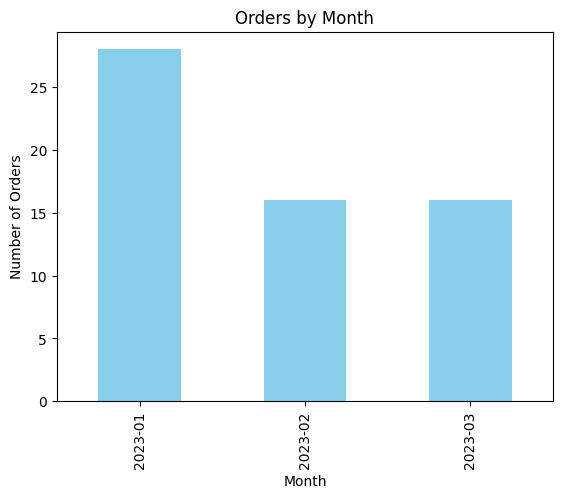

In [23]:
# 1. Analyze Orders by Time
if 'OrderDate' in orders_df.columns:
    orders_df['OrderDate'] = pd.to_datetime(orders_df['OrderDate'], errors='coerce')
    orders_df['Month'] = orders_df['OrderDate'].dt.to_period('M')

    # Distribution of Orders by Month
    order_by_month = orders_df['Month'].value_counts().sort_index()
    order_by_month.plot(kind='bar', title='Orders by Month', color='skyblue')
    plt.ylabel('Number of Orders')
    plt.show()


Order Distribution by Product Category:
Category
Electronics    0.601942
Accessories    0.398058
Name: proportion, dtype: float64


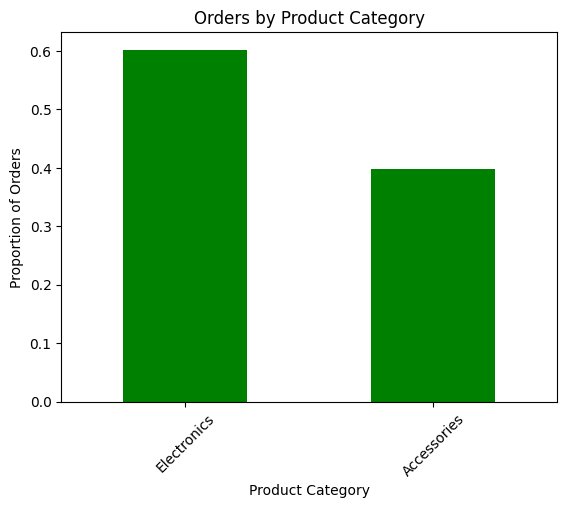

In [28]:
#2. Analyze Orders by Product Category
if 'ProductID' in order_details_df.columns and 'Category' in products_df.columns:
    # Merge Orders with Products to get Category information
    merged_df1 = order_details_df.merge(products_df, on='ProductID', how='left')

    # Calculate category distribution
    category_distribution = merged_df1['Category'].value_counts(normalize=True)
    print("\nOrder Distribution by Product Category:")
    print(category_distribution)

    # Visualize Product Category Distribution
    category_distribution.plot(kind='bar', title='Orders by Product Category', color='green')
    plt.xlabel('Product Category')
    plt.ylabel('Proportion of Orders')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("\nError: 'ProductID' or 'Category' column not found in the respective DataFrames.")

### Update the original order_details_df with TotalPrice


In [29]:
creds = service_account.Credentials.from_service_account_file('/content/wie3007ia-196c883db361.json')

# Merge order_details with products to get price
merged_order_details = order_details_df.merge(products_df[['ProductID', 'Price']], on='ProductID')

merged_order_details['TotalPrice'] = merged_order_details['Price'] * merged_order_details['Quantity']

order_details_df['TotalPrice'] = order_details_df['OrderDetailsID'].map(
    merged_order_details.set_index('OrderDetailsID')['TotalPrice']
)

print(order_details_df)


     OrderID  ProductID  Quantity  Discount OrderDetailsID  TotalPrice
0        301        201         2      0.00        301_201        2000
1        302        202        10      0.10        302_202        5000
2        303        203         1      0.00        303_203         800
3        304        204        32      0.00        304_204        6400
4        305        205         1      0.00        305_205         300
..       ...        ...       ...       ...            ...         ...
98       358        202        16      0.06        358_202        8000
99       359        203        13      0.00        359_203       10400
100      359        209        15      0.05        359_209        3750
101      359        207        15      0.00        359_207        1500
102      360        208        37      0.13        360_208       11100

[103 rows x 6 columns]


## Entity Set

In [30]:
# creating entity set 'entitySet'
entitySet = ft.EntitySet(id="e-commerce_es")

#Add DataFrame to the EntitySet
#Customers
customers_entity = entitySet.add_dataframe(
    dataframe=customers_df,  #  Dataframe containing the data.
    dataframe_name='Customers',  # Unique name to associate with this dataframe
    index='CustomerID',  # Unique identifier
    time_index='SignupDate'
)

#Products
products_entity = entitySet.add_dataframe(
    dataframe=products_df,
    dataframe_name='Products',
    index='ProductID'
)

#Orders
orders_entity = entitySet.add_dataframe(
    dataframe=orders_df,
    dataframe_name='Orders',
    index='OrderID' ,
    time_index='OrderDate',
)

#OrdersDetails
orderDetails_entity = entitySet.add_dataframe(
    dataframe=order_details_df,
    dataframe_name='OrderDetails',
    index='OrderDetailsID'
)

/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. 

In [31]:
print(entitySet)

Entityset: e-commerce_es
  DataFrames:
    Customers [Rows: 10, Columns: 6]
    Products [Rows: 10, Columns: 4]
    Orders [Rows: 60, Columns: 7]
    OrderDetails [Rows: 103, Columns: 6]
  Relationships:
    No relationships


####Establish relationship

In [32]:
# Define relationships
entitySet.add_relationship(parent_dataframe_name='Customers', parent_column_name='CustomerID',
                    child_dataframe_name='Orders', child_column_name='CustomerID')

entitySet.add_relationship(parent_dataframe_name='Products', parent_column_name='ProductID',
                    child_dataframe_name='OrderDetails', child_column_name='ProductID')

entitySet.add_relationship(parent_dataframe_name='Orders', parent_column_name='OrderID',
                    child_dataframe_name='OrderDetails', child_column_name='OrderID')

Entityset: e-commerce_es
  DataFrames:
    Customers [Rows: 10, Columns: 6]
    Products [Rows: 10, Columns: 4]
    Orders [Rows: 60, Columns: 7]
    OrderDetails [Rows: 103, Columns: 6]
  Relationships:
    Orders.CustomerID -> Customers.CustomerID
    OrderDetails.ProductID -> Products.ProductID
    OrderDetails.OrderID -> Orders.OrderID

####Check entity relationship

In [33]:
print(entitySet)

Entityset: e-commerce_es
  DataFrames:
    Customers [Rows: 10, Columns: 6]
    Products [Rows: 10, Columns: 4]
    Orders [Rows: 60, Columns: 7]
    OrderDetails [Rows: 103, Columns: 6]
  Relationships:
    Orders.CustomerID -> Customers.CustomerID
    OrderDetails.ProductID -> Products.ProductID
    OrderDetails.OrderID -> Orders.OrderID


#Deep Feature Synthesis (DFS)

In [34]:
  # Generate features with DFS for Orders fact table
  feature_matrix, feature_defs = ft.dfs(
      entityset=entitySet,
      target_dataframe_name="Orders",
      verbose=True,
      max_depth=3,
      agg_primitives=['sum', 'mean', 'count', 'max', 'min','mode'],
      trans_primitives=['month', 'day', 'year']
  )

Built 147 features
Elapsed: 00:00 | Progress:  31%|███       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:785: FutureWarning: The provided callable <function max at 0x7ed8f6a08ca0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  ).agg(to_agg)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:785: FutureWarning: The provided callable <function min at 0x7ed8f6a08dc0> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  ).agg(to_agg)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:785: FutureWarning: The provided callable <function mean at 0x7ed8f6a095a0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will

Elapsed: 00:00 | Progress: 100%|██████████


###Display the entire feature matrix

Too long no show out

In [36]:
# # Display the entire feature matrix
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.max_rows', None)     # Show all rows
# print(feature_matrix)


In [37]:
grouped_columns = {
    'MAX': [col for col in feature_matrix.columns if col.startswith('MAX')],
    'MIN': [col for col in feature_matrix.columns if col.startswith('MIN')],
    'MEAN': [col for col in feature_matrix.columns if col.startswith('MEAN')],
    'SUM': [col for col in feature_matrix.columns if col.startswith('SUM')],
    'Other': [col for col in feature_matrix.columns if not any(col.startswith(prefix) for prefix in ['MAX', 'MIN', 'MEAN', 'SUM'])]
}

# Print grouped columns
for group, columns in grouped_columns.items():
    print(f"\n{group} Columns:")
    for column in columns:
        print(f" - {column}")


MAX Columns:
 - MAX(OrderDetails.Discount)
 - MAX(OrderDetails.Quantity)
 - MAX(OrderDetails.TotalPrice)
 - MAX(OrderDetails.Products.Price)
 - MAX(OrderDetails.Products.COUNT(OrderDetails))
 - MAX(OrderDetails.Products.MEAN(OrderDetails.Discount))
 - MAX(OrderDetails.Products.MEAN(OrderDetails.Quantity))
 - MAX(OrderDetails.Products.MEAN(OrderDetails.TotalPrice))
 - MAX(OrderDetails.Products.MIN(OrderDetails.Discount))
 - MAX(OrderDetails.Products.MIN(OrderDetails.Quantity))
 - MAX(OrderDetails.Products.MIN(OrderDetails.TotalPrice))
 - MAX(OrderDetails.Products.SUM(OrderDetails.Discount))
 - MAX(OrderDetails.Products.SUM(OrderDetails.Quantity))
 - MAX(OrderDetails.Products.SUM(OrderDetails.TotalPrice))

MIN Columns:
 - MIN(OrderDetails.Discount)
 - MIN(OrderDetails.Quantity)
 - MIN(OrderDetails.TotalPrice)
 - MIN(OrderDetails.Products.Price)
 - MIN(OrderDetails.Products.COUNT(OrderDetails))
 - MIN(OrderDetails.Products.MAX(OrderDetails.Discount))
 - MIN(OrderDetails.Products.MAX(Orde

#Insight

In [38]:
merged_data = feature_matrix.reset_index().merge(customers_df[['CustomerID', 'Name']], on='CustomerID', how='left')


In [39]:
display(merged_data)

,OrderID,CustomerID,IsOrderDateValid,IsShipDateValid,COUNT(OrderDetails),MAX(OrderDetails.Discount),MAX(OrderDetails.Quantity),MAX(OrderDetails.TotalPrice),MEAN(OrderDetails.Discount),MEAN(OrderDetails.Quantity),MEAN(OrderDetails.TotalPrice),MIN(OrderDetails.Discount),MIN(OrderDetails.Quantity),MIN(OrderDetails.TotalPrice),SUM(OrderDetails.Discount),SUM(OrderDetails.Quantity),SUM(OrderDetails.TotalPrice),DAY(Month),DAY(OrderDate),DAY(ShipDate),MONTH(Month),MONTH(OrderDate),MONTH(ShipDate),YEAR(Month),YEAR(OrderDate),YEAR(ShipDate),Customers.IsEmailValid,Customers.IsSignupDateValid,MAX(OrderDetails.Products.Price),MEAN(OrderDetails.Products.Price),MIN(OrderDetails.Products.Price),MODE(OrderDetails.Products.Category),SUM(OrderDetails.Products.Price),Customers.COUNT(Orders),Customers.COUNT(OrderDetails),Customers.MAX(OrderDetails.Discount),Customers.MAX(OrderDetails.Quantity),Customers.MAX(OrderDetails.TotalPrice),Customers.MEAN(OrderDetails.Discount),Customers.MEAN(OrderDetails.Quantity),Customers.MEAN(OrderDetails.TotalPrice),Customers.MIN(OrderDetails.Discount),Customers.MIN(OrderDetails.Quantity),Customers.MIN(OrderDetails.TotalPrice),Customers.SUM(OrderDetails.Discount),Customers.SUM(OrderDetails.Quantity),Customers.SUM(OrderDetails.TotalPrice),Customers.DAY(SignupDate),Customers.MONTH(SignupDate),Customers.YEAR(SignupDate),MAX(OrderDetails.Products.COUNT(OrderDetails)),MAX(OrderDetails.Products.MEAN(OrderDetails.Discount)),MAX(OrderDetails.Products.MEAN(OrderDetails.Quantity)),MAX(OrderDetails.Products.MEAN(OrderDetails.TotalPrice)),MAX(OrderDetails.Products.MIN(OrderDetails.Discount)),MAX(OrderDetails.Products.MIN(OrderDetails.Quantity)),MAX(OrderDetails.Products.MIN(OrderDetails.TotalPrice)),MAX(OrderDetails.Products.SUM(OrderDetails.Discount)),MAX(OrderDetails.Products.SUM(OrderDetails.Quantity)),MAX(OrderDetails.Products.SUM(OrderDetails.TotalPrice)),MEAN(OrderDetails.Products.COUNT(OrderDetails)),MEAN(OrderDetails.Products.MAX(OrderDetails.Discount)),MEAN(OrderDetails.Products.MAX(OrderDetails.Quantity)),MEAN(OrderDetails.Products.MAX(OrderDetails.TotalPrice)),MEAN(OrderDetails.Products.MEAN(OrderDetails.Discount)),MEAN(OrderDetails.Products.MEAN(OrderDetails.Quantity)),MEAN(OrderDetails.Products.MEAN(OrderDetails.TotalPrice)),MEAN(OrderDetails.Products.MIN(OrderDetails.Discount)),MEAN(OrderDetails.Products.MIN(OrderDetails.Quantity)),MEAN(OrderDetails.Products.MIN(OrderDetails.TotalPrice)),MEAN(OrderDetails.Products.SUM(OrderDetails.Discount)),MEAN(OrderDetails.Products.SUM(OrderDetails.Quantity)),MEAN(OrderDetails.Products.SUM(OrderDetails.TotalPrice)),MIN(OrderDetails.Products.COUNT(OrderDetails)),MIN(OrderDetails.Products.MAX(OrderDetails.Discount)),MIN(OrderDetails.Products.MAX(OrderDetails.Quantity)),MIN(OrderDetails.Products.MAX(OrderDetails.TotalPrice)),MIN(OrderDetails.Products.MEAN(OrderDetails.Discount)),MIN(OrderDetails.Products.MEAN(OrderDetails.Quantity)),MIN(OrderDetails.Products.MEAN(OrderDetails.TotalPrice)),MIN(OrderDetails.Products.SUM(OrderDetails.Discount)),MIN(OrderDetails.Products.SUM(OrderDetails.Quantity)),MIN(OrderDetails.Products.SUM(OrderDetails.TotalPrice)),SUM(OrderDetails.Products.MAX(OrderDetails.Discount)),SUM(OrderDetails.Products.MAX(OrderDetails.Quantity)),SUM(OrderDetails.Products.MAX(OrderDetails.TotalPrice)),SUM(OrderDetails.Products.MEAN(OrderDetails.Discount)),SUM(OrderDetails.Products.MEAN(OrderDetails.Quantity)),SUM(OrderDetails.Products.MEAN(OrderDetails.TotalPrice)),SUM(OrderDetails.Products.MIN(OrderDetails.Discount)),SUM(OrderDetails.Products.MIN(OrderDetails.Quantity)),SUM(OrderDetails.Products.MIN(OrderDetails.TotalPrice)),Customers.MAX(Orders.COUNT(OrderDetails)),Customers.MAX(Orders.MEAN(OrderDetails.Discount)),Customers.MAX(Orders.MEAN(OrderDetails.Quantity)),Customers.MAX(Orders.MEAN(OrderDetails.TotalPrice)),Customers.MAX(Orders.MIN(OrderDetails.Discount)),Customers.MAX(Orders.MIN(OrderDetails.Quantity)),Customers.MAX(Orders.MIN(OrderDetails.TotalPrice)),Customers.M

##Top Ordered Products

In [40]:
# Sort the feature matrix by 'MAX(OrderDetails.Quantity)' in descending order and get the top 10
top_10_quantities = merged_data[['Name', 'MAX(OrderDetails.Quantity)', 'OrderID']].sort_values(by='MAX(OrderDetails.Quantity)', ascending=False).head(10)

print(top_10_quantities)


             Name  MAX(OrderDetails.Quantity)  OrderID
25    Alice Brown                        50.0      343
44  Charlie Davis                        50.0      308
10   Emily Wilson                        49.0      344
53    Bob Johnson                        47.0      334
38    Mike Jordan                        47.0      340
24    Chris Evans                        47.0      313
22   Emily Wilson                        47.0      353
59    Alice Brown                        46.0      314
14   David Garcia                        44.0      354
20    Mike Jordan                        44.0      336


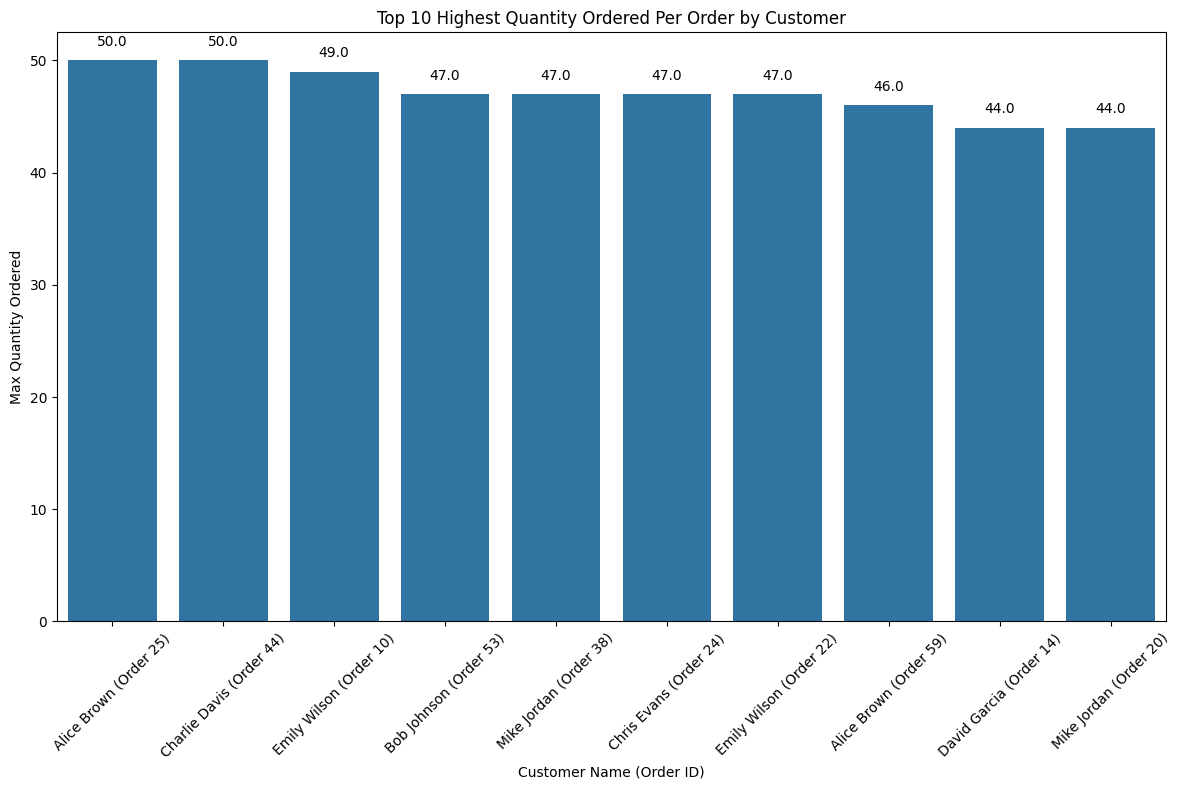

In [41]:
# Create a new column that combines 'CustomerName' and 'OrderID' for unique labels
top_10_quantities['CustomerOrder'] = top_10_quantities['Name'] + " (Order " + top_10_quantities.index.astype(str) + ")"


plt.figure(figsize=(12, 8))
sns.barplot(x='CustomerOrder', y='MAX(OrderDetails.Quantity)', data=top_10_quantities)
plt.title("Top 10 Highest Quantity Ordered Per Order by Customer")
plt.xlabel("Customer Name (Order ID)")
plt.ylabel("Max Quantity Ordered")

# Adding exact quantity values on top of each bar
for index, value in enumerate(top_10_quantities['MAX(OrderDetails.Quantity)']):
    plt.text(index, value + 1, round(value, 2), ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##Highest Revenue Orders (Make by customer)

In [42]:
#Aggregate to get total revenue per OrderID and Customer (Name)
top_revenue_orders = merged_data.groupby(['OrderID', 'Name'])['SUM(OrderDetails.TotalPrice)'].sum().reset_index()
# Sort by revenue in descending order and select the top 10
top_revenue_orders = top_revenue_orders.sort_values(by='SUM(OrderDetails.TotalPrice)', ascending=False).head(10)
print("Highest Revenue Per Order:")
print(top_revenue_orders)

Highest Revenue Per Order:
    OrderID           Name  SUM(OrderDetails.TotalPrice)
42      343    Alice Brown                       65550.0
52      353   Emily Wilson                       56000.0
33      334    Bob Johnson                       54700.0
12      313    Chris Evans                       47000.0
13      314    Alice Brown                       44800.0
48      349   David Garcia                       42300.0
54      355   David Garcia                       41950.0
50      351  Charlie Davis                       37800.0
19      320    Bob Johnson                       37500.0
45      346   David Garcia                       36100.0


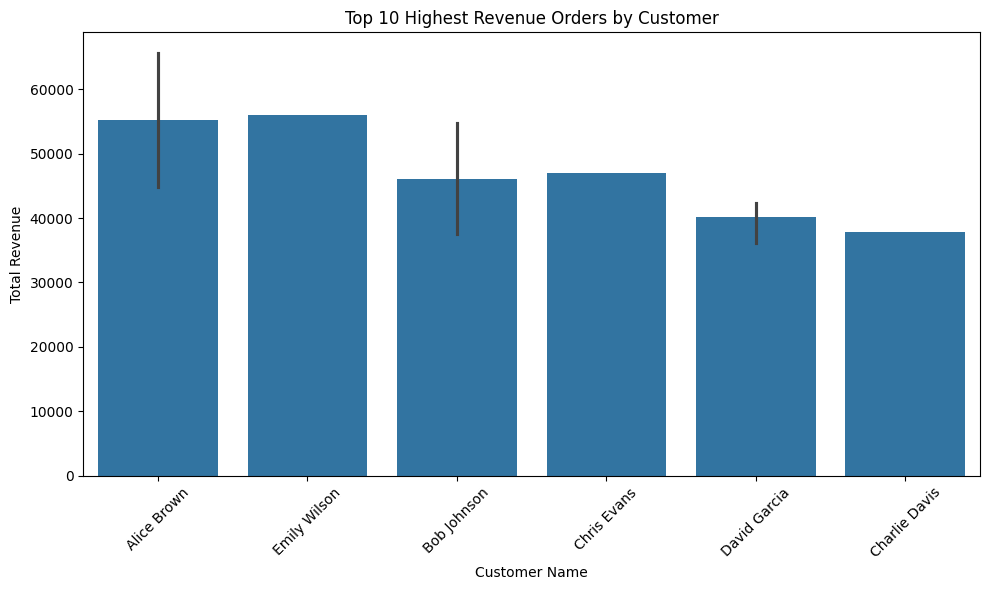

In [43]:
# Step 1: Aggregate to get total revenue per OrderID and Name (customer)
top_revenue_orders = merged_data.groupby(['OrderID', 'Name'])['SUM(OrderDetails.TotalPrice)'].sum().reset_index()

# Step 2: Sort by revenue in descending order and select the top 10
top_revenue_orders = top_revenue_orders.sort_values(by='SUM(OrderDetails.TotalPrice)', ascending=False).head(10)

# Step 3: Plotting, ensuring all rows are shown
plt.figure(figsize=(10, 6))
sns.barplot(x='Name', y='SUM(OrderDetails.TotalPrice)', data=top_revenue_orders)
plt.title("Top 10 Highest Revenue Orders by Customer")
plt.xlabel("Customer Name")
plt.ylabel("Total Revenue")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##Top 10 Customers by Number of Orders



In [44]:
orders_per_customer = merged_data.groupby('Name')['OrderID'].count().nlargest(10)
print("Top Customers by Number of Orders:")
print(orders_per_customer)

Top Customers by Number of Orders:
Name
Chris Evans      12
Bob Johnson       9
Emily Wilson      9
Mike Jordan       7
John Doe          6
Alice Brown       5
David Garcia      5
Charlie Davis     4
Jane Smith        2
Emma Stone        1
Name: OrderID, dtype: int64


<ipython-input-45-439a533cd827>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=orders_per_customer.index, y=orders_per_customer.values, palette='Purples')


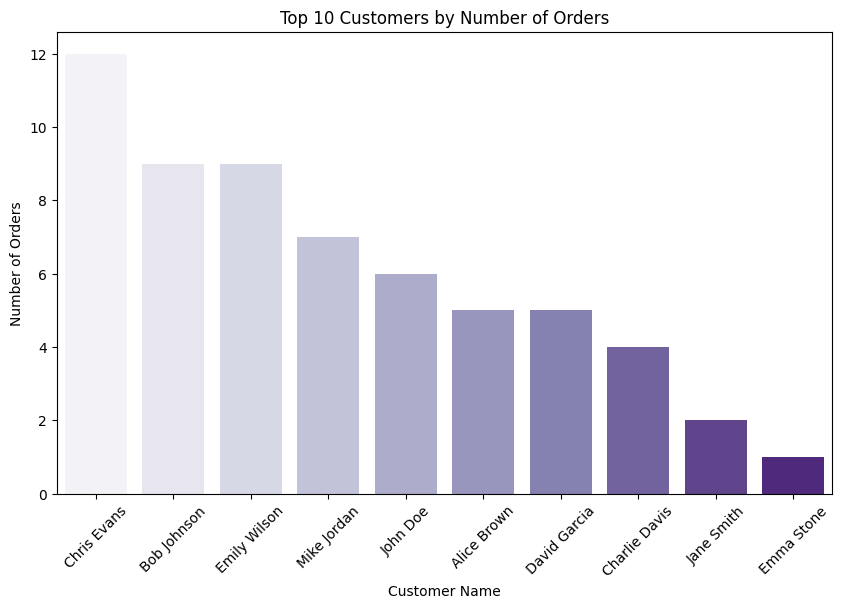

In [45]:
creds = service_account.Credentials.from_service_account_file('/content/wie3007ia-196c883db361.json')
# Group by CustomerName to show the number of orders per customer
orders_with_customers = orders_df.merge(customers_df, on='CustomerID')

orders_per_customer = orders_with_customers.groupby('Name')['OrderID'].count().nlargest(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=orders_per_customer.index, y=orders_per_customer.values, palette='Purples')
plt.title('Top 10 Customers by Number of Orders')
plt.xlabel('Customer Name')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.show()

##Most Common Order Day

<ipython-input-46-e44d0685cdda>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=common_order_day.index, y=common_order_day.values, palette='Set2')


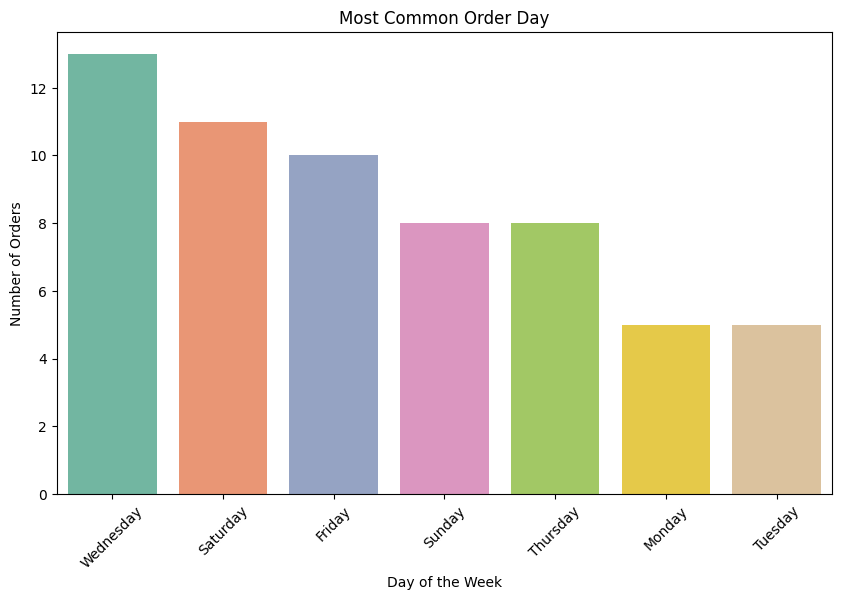

In [46]:
orders_df['OrderDay'] = orders_df['OrderDate'].dt.day_name()
common_order_day = orders_df['OrderDay'].value_counts()


plt.figure(figsize=(10, 6))
sns.barplot(x=common_order_day.index, y=common_order_day.values, palette='Set2')
plt.title('Most Common Order Day')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.show()

##Most Common Product Category Ordered

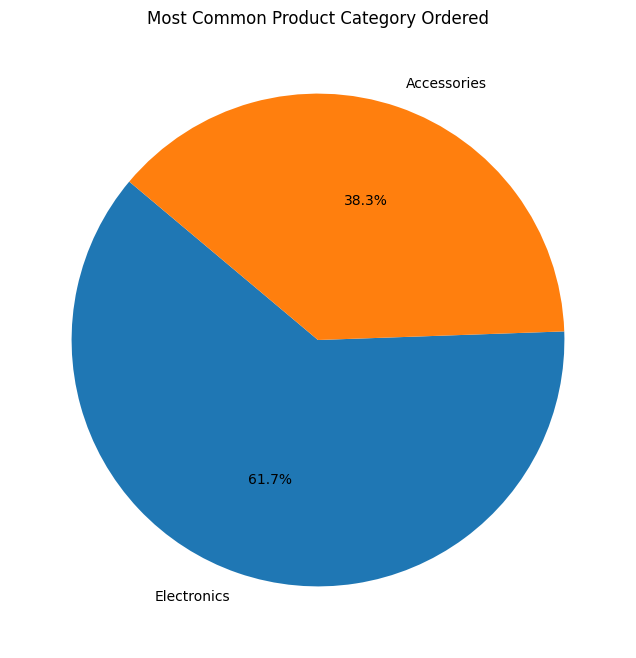

In [47]:
category_counts = feature_matrix["MODE(OrderDetails.Products.Category)"].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Most Common Product Category Ordered")
plt.show()

In [48]:
feature_matrix.to_csv('feature_matrix.csv', index=False)

#Trigger Feature Engineering

In [ ]:
def trigger_feature_engineering():
    entitySet = ft.EntitySet(id="e-commerce_es")

#Customer
customers_entity = entitySet.add_dataframe(
    dataframe=customers_df,  #  Dataframe containing the data.
    dataframe_name='Customers',  # Unique name to associate with this dataframe
    index='CustomerID',  # Unique identifier
    time_index='SignupDate'
)

#Products
products_entity = entitySet.add_dataframe(
    dataframe=products_df,
    dataframe_name='Products',
    index='ProductID'
)

#Orders
orders_entity = entitySet.add_dataframe(
    dataframe=orders_df,
    dataframe_name='Orders',
    index='OrderID' ,
    time_index='OrderDate',
)

#OrdersDetails
orderDetails_entity = entitySet.add_dataframe(
    dataframe=order_details_df,
    dataframe_name='OrderDetails',
    index='OrderDetailsID'
)

# Define relationships
entitySet.add_relationship(parent_dataframe_name='Customers', parent_column_name='CustomerID',
                    child_dataframe_name='Orders', child_column_name='CustomerID')

entitySet.add_relationship(parent_dataframe_name='Products', parent_column_name='ProductID',
                    child_dataframe_name='OrderDetails', child_column_name='ProductID')

entitySet.add_relationship(parent_dataframe_name='Orders', parent_column_name='OrderID',
                    child_dataframe_name='OrderDetails', child_column_name='OrderID')

# Generate features with DFS for Orders fact table
  feature_matrix, feature_defs = ft.dfs(
      entityset=entitySet,
      target_dataframe_name="Orders",
      verbose=True,
      max_depth=3,
      agg_primitives=['sum', 'mean', 'count', 'max', 'min','mode'],
      trans_primitives=['month', 'day', 'year']
  )

    print("Feature Engineering Completed!")
    print(feature_matrix.head())
    return feature_matrix

# Trigger feature engineering after receiving enough updates
feature_matrix = trigger_feature_engineering()
